In [1]:
import math # cos() for Rastrigin
import copy # array-copying convenience
import sys # max float
import numpy as np
import sympy as sp
from sympy.plotting import plot
from sympy.plotting import plot3d
import matplotlib.pyplot as plt
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import gym
from gym.spaces import Box, Discrete, MultiDiscrete

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
## parameter/ constant
bandwidth = 1e6  # [hz]
Speed_of_light = 3e8  # [m/s]
Carrier_freq = 2e9  # [hz]=1/s
GBS_location = [0,0,20] #[m] 20
Num_GBS = 1
# NUM_User = 10
NUM_UAV = 2
Cell_Radius = 1000 #[m]
UAV_Height = 100#100 #[m] "Cell-Edge User Offloading via Flying UAV in Non-Uniform Heterogeneous Cellular Networks," in IEEE Transactions on Wireless Communications, vol. 19, no. 4, pp. 2411-2426, April 2020, doi: 10.1109/TWC.2020.2964656.
P_UAV = 10 **(37 / 10) / 1000 #[watt] 
P_GBS = 10 **(40 / 10) / 1000 #[watt]
P_MAX = 0.4 # 26dbm, user
# P_MIN = 0.1 # 20 dbm
epsilon = 0.38 # power amplifier efficiency
AWGN_DBM = -174 #[dBm]
AWGN_W = 10 ** (AWGN_DBM / 10) / 1000
air_density = 1.225 # Air density at sea level (kg/m³)
g = 9.81            # Gravitational acceleration (m/s²)
mass = 0.5           # Mass of UAV in kg
radius = 0.2         # Rotor radius in meters
num_rotors = 4
P_MOVE =10 #[watt]
V = 20 # m/s


In [4]:
#Area
AREA_WIDTH = 1000 #[m]
def random_position():
    # Generate a random position within the area
    x = np.random.uniform(-Cell_Radius, Cell_Radius)
    y = np.random.uniform(-Cell_Radius, Cell_Radius)
    return (x, y, 0)

User_position = []
for i in range(45):
    User_position.append(random_position())

UAV_2D = []
for i in range(2):
    UAV_2D.append(random_position())

UAV_position=[]
for i in range(2):
    # Convert to a list to modify it
    temp_list = list(UAV_2D[i])
    temp_list[2] = UAV_Height
    updated_tuple = tuple(temp_list)
    print(temp_list)
    UAV_position.append(updated_tuple)

[-729.4189613239271, -780.1163175360888, 100]
[425.103185004702, -780.1194022516275, 100]


In [5]:
User_position

[(-908.4801300656451, 683.9900070210247, 0),
 (312.55849247864694, -828.3753987303581, 0),
 (485.11024838124536, 506.0763276544785, 0),
 (-285.90632039574973, -970.9854282656132, 0),
 (580.0200126578279, -260.0791282080593, 0),
 (644.778984771852, 742.139005047814, 0),
 (743.2730100776821, -627.1240220261767, 0),
 (-842.4429446846377, 143.6956842563061, 0),
 (858.4198156806176, 412.47873081971466, 0),
 (-131.00479394776562, 207.8413021989354, 0),
 (-410.4236473908918, -526.594380324934, 0),
 (-36.72012476296868, 993.8934794919021, 0),
 (-232.35840414959898, -886.4963944858208, 0),
 (-691.4339521488262, -680.2587433285654, 0),
 (795.2400122765739, -477.3135431535684, 0),
 (61.45066404228601, 590.5026169618814, 0),
 (-930.5683187703642, -507.89585777181867, 0),
 (508.05490561350666, 154.9112744344052, 0),
 (-396.66981141480835, 716.3134775994859, 0),
 (-130.1065139722872, 264.02128791531163, 0),
 (-354.8370237608523, -681.9844420597312, 0),
 (-475.3894860683961, -160.3363016944537, 0),
 

In [6]:
def init_uav_positions(NUM_UAV, UAV_Height, random_position):

    UAV_2D = [random_position() for _ in range(NUM_UAV)]
    UAV_positions = []
    
    for i in range(NUM_UAV):
        temp_list = list(UAV_2D[i])
        temp_list[2] = UAV_Height
        updated_tuple = tuple(temp_list)
        # print(temp_list)
        UAV_positions.append(updated_tuple)
    
    return UAV_positions

In [7]:
# initail location UAVs
UAV_position =np.array(UAV_position)
UAV_position

array([[-729.41896132, -780.11631754,  100.        ],
       [ 425.103185  , -780.11940225,  100.        ]])

In [ ]:
# Fixed location User
User_position = [
(653.8316581607805, -590.3141344883956, 0),
 (655.7839795019095, 511.39715579708627, 0),
 (-366.9200930533958, -378.53106855942656, 0),
 (774.0710077290566, -813.74371579118, 0),
 (-902.1513920204236, 689.4058695488745, 0),
 (-887.8742394199635, 629.5122712145035, 0),
 (-480.4469889568361, -411.7900064526441, 0),
 (-584.0565231366488, -207.29087777276175, 0),
 (917.8907259745158, -388.6065319450123, 0),
 (482.22239122176074, 382.7717524589923, 0),
#  (75.08205947,	-246.6113445,	0),
# (89.08034796,	93.40797308	,0),
# (539.8534823,	-160.3015493,	0),
# (139.7089773,	716.6716587	,0),
# (-569.3566777,	263.1666404	,0),
# (-90.29446879,	-288.6084637	,0),
# (-767.5899487,	-135.3924119,	0),
# (773.8435759	,-235.8694596	,0),
# (613.2944812	,608.7494777	,0),
# (204.2851089	,-171.0078052	,0),
# (386.1443989	,-926.5117843	,0),
# (-938.0904915	,99.43896713	,0),
# (-937.1604717,	-444.6725165	,0),
# (694.8819289	,668.5820704	,0),
# (834.6212365	,987.1367586,	0),
# (348.2927666	,-81.11493568	,0),
# (-955.8690815	,81.17473736	,0),
# (-545.2280657	,977.3220921	,0),
# (-700.3981729	,-579.959419	,0),
# (653.7133739	,-669.164471	,0),
]

In [9]:
NUM_User = len(User_position)
NUM_User

10

In [10]:
#Calculate Distance
def distance(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
D_n_bs = np.zeros((NUM_UAV + Num_GBS, NUM_User))
D_n_bs

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [11]:
# # Calcualte distance store in Matrix
# UAV_position = np.array([[-483.06727465,   31.1365344 ,  100.        ],
#        [ 871.15504185, -927.74625029,  100.        ]])
# #UAV1
# for j in range(NUM_User):
#     uav_pos = UAV_position[0]
#     user_pos = User_position[j]
#     calculated_distance = distance(x1 = uav_pos[0], y1 = uav_pos[1], z1 = uav_pos[2], x2 = user_pos[0], y2 = user_pos[1], z2 = user_pos[2])
    
#     # Store the calculated distance in the matrix
#     D_n_bs[0][j] = calculated_distance

# #UAV2
# for j in range(NUM_User):
#     uav_pos = UAV_position[1]
#     user_pos = User_position[j]
#     calculated_distance = distance(x1 = uav_pos[0], y1 = uav_pos[1], z1 = uav_pos[2], x2 = user_pos[0], y2 = user_pos[1], z2 = user_pos[2])
#     D_n_bs[1][j] = calculated_distance

# #Ground BS
# for j in range(NUM_User):
#     user_pos = User_position[j]
#     calculated_distance = distance(x1 = GBS_location[0], y1 = GBS_location[1], z1 = GBS_location[2], x2 = user_pos[0], y2 = user_pos[1], z2 = user_pos[2])
#     D_n_bs[2][j] = calculated_distance    
    
# # print("distance user to all base staion",D_n_bs)

In [ ]:
#pathloss, unitless
def gain_n(distance):
    c = Speed_of_light
    f= Carrier_freq
    pi = np.pi
    return (c/(4*pi*f*distance))**(2)


In [13]:
#Generte link selection
def generate_matrix_and_assign_users(rows=3, cols=10):
    while True:
        matrix_selection = np.zeros((rows, cols), dtype=int)
        for col in range(cols):
            row_idx = np.random.randint(0, rows)
            matrix_selection[row_idx, col] = 1
        
        # Calculate row sums
        tmp = np.sum(matrix_selection, axis=1)
        if tmp[0] > 0 and tmp[1] > 0:
            break
    
    # Determine user assignments based on the matrix
    UAV1_user = np.argwhere(matrix_selection[0] == 1).T[0].tolist()
    UAV2_user = np.argwhere(matrix_selection[1] == 1).T[0].tolist()
    GBS_user = np.argwhere(matrix_selection[2] == 1).T[0].tolist()
    
    return matrix_selection, UAV1_user, UAV2_user, GBS_user
matrix_selection, UAV1_user, UAV2_user, GBS_user = generate_matrix_and_assign_users()

In [14]:
# generate selectionn not yet set constraint
import random
rows = 3
cols = 10
while True:
    matrix_selection = np.zeros((rows, cols), dtype=int) # matrix
    for col in range(cols):
        row_idx = np.random.randint(0, rows)
        matrix_selection[row_idx, col] = 1
    tmp = np.sum(matrix_selection, axis=1)
    # print(tmp[0])
    if tmp[0] > 0 and tmp[1] > 0:
        break
UAV1_user = np.argwhere(matrix_selection[0] == 1).T[0].tolist()
UAV2_user = np.argwhere(matrix_selection[1] == 1).T[0].tolist()
GBS_user = np.argwhere(matrix_selection[2] == 1).T[0].tolist()

In [15]:
# # SINR with NOMA in same coverage of UAV1
# num_tslot =24
# time_slots = np.arange(0, num_tslot)
power_min = 0.1
power_max = P_UAV

p_u1_level = np.random.uniform(power_min, power_max, len(UAV1_user))
p_u1_normalize = p_u1_level / np.sum(p_u1_level) * power_max
power_sort = sorted(p_u1_normalize)
power_sort

[0.5072862807730497,
 0.6024409791516868,
 1.0126984768954181,
 1.2447468737085794,
 1.6446997257439901]

In [17]:
# SINR
def noma_sinr(channel_conditions, selected_users, powers, transmitter_id):
    if not selected_users:
        return [], []
    
    gains = [channel_conditions[transmitter_id, user] for user in selected_users]
    # Sort users by channel gain (strongest first)
    sorted_indices = np.argsort(gains)[::-1]  # Descending order
    sorted_users = [selected_users[i] for i in sorted_indices]
    sorted_gains = [gains[i] for i in sorted_indices]
    sinrs = []
    for i, user in enumerate(sorted_indices):
        interference = 0
        sinr = (powers[user] * sorted_gains[user]) / (AWGN_W + interference)
        sinrs.append(sinr)
    
    return sinrs, selected_users
sinrs = noma_sinr(gain_n(D_n_bs), UAV1_user, power_sort, 0)
sinrs

C:\Users\ASUS VIVOBOOK\AppData\Local\Temp\ipykernel_10040\2543804948.py:6: RuntimeWarning: divide by zero encountered in divide
  return (c/(4*pi*f*distance))**(2)


([inf, inf, inf, inf, inf], [0, 1, 6, 7, 9])

In [18]:
#Data rate
num_user = NUM_User
sorted_users = sinrs[1]
sorted_users_sinr = sinrs[0]
def calculate_transmission_rate(sinr, num_user):
    """Calculate achievable rate using Shannon capacity"""
    if num_user == 0:
        num_user = 1
    # print("bandwidth",int(bandwidth))
    # print("bandwidth for users",int(bandwidth/num_user))
    return (int(bandwidth/num_user) * np.log2(1 + sinr))/1e6 # MHz

rate_n = calculate_transmission_rate(np.array(sorted_users_sinr), 1)
rate_n

array([inf, inf, inf, inf, inf])

In [ ]:
# # 10 user
traffic_data = np.array([ 8.795845 ,  4.476116 ,  5.5037837,  6.0243654, 12.920729 ,
        5.5970373,  6.0550256,  4.872516 ,  7.577386 ,  9.967498 ])
# # #15 user
# traffic_data = np.array([14.2345, 4.7710037, 7.6004195, 7.6562877, 22.904835, 10.31743,
#                          10.02901, 10.140568, 13.525869, 17.060368, 20.13406, 3.3490102, 
#                          17.419847, 15.829944, 6.5886827 ])
# 20 user
# traffic_data = np.array([15.045018, 6.545699, 7.0056453, 7.0192256, 26.408241, 9.260441, 
#                          10.931942, 8.048492, 12.15611, 15.898077, 19.099787, 4.9521737,
#                            17.933542, 14.467922, 9.955734, 13.156038, 21.471113, 10.216565, 8.602531, 17.791065])

#25 user
# traffic_data = np.array([14.101378, 6.327937, 6.9734707, 7.705143, 24.17083, 8.45224, 10.937698,
#                           7.165816, 13.620338, 16.299187, 21.602406, 4.3687615, 18.788303, 16.177567, 
#                           8.267505, 15.565486, 23.637806, 11.268315, 8.559526, 16.202307, 17.567959, 23.138298, 
#                           19.848198, 4.852388, 10.035355])

# 30 user
# traffic_data = np.array([13.730608, 5.326337, 6.305037, 8.3221855, 24.156334, 9.056003, 11.426689, 11.308687, 
#                          13.707179, 16.739891, 22.561272, 4.2011957, 16.53558, 13.905987, 4.317765, 14.405717, 
#                          23.871864, 11.336344, 9.031543, 19.897724, 16.41292, 19.279444, 18.578587, 5.886368, 8.510113,
#                            8.288387, 10.033254, 18.78224, 12.353946, 24.130177])


In [23]:
action_raw = [0.7695283, 0.12465111, -0.6061603, 1.0, 1.0, 1.0, 0.804409, 1.0, 0.747946, -0.5200442, 1.0, 1.0, 1.0, 1.0, -0.09169996, 1.0, -0.36757523, 1.0, -0.3259506, -0.36846933, 1.0, 1.0, 1.0, 1.0,
             ]  


In [25]:
# Find max Rate
max_band_ratio = 1
distance_min = 100 #meter
P_MAX_user =  P_UAV/num_user#0.5011872336272725 
max_gain = gain_n(distance_min)
max_sinr = ( P_MAX_user* max_gain) / (AWGN_W )
max_rate = (max_band_ratio * bandwidth) * np.log2(1 + max_sinr)/1e6 # MHz
max_rate

40.70611888041029

In [ ]:
#power constrains

# Define the max power for the UAV
P_max = P_UAV 
num_users = NUM_User
P_min = 0.001  
P_max_user = 0.5011872336272725  

# Define the scaling function to map DDPG actions (-1 to 1) to power allocations
def scale_action_to_power(action, P_min, P_max_user):
    return (action + 1) / 2 * (P_max_user - P_min) + P_min

# Function to ensure total power does not exceed P_max
def control_power_allocation(actions, P_max):
    power_allocations = scale_action_to_power(actions, P_min, P_max_user)
    total_power = np.sum(power_allocations)
    
    # Step 3: If total power exceeds P_max, scale down allocations proportionally
    if total_power > P_max:
        scaling_factor = P_max / total_power
        power_allocations = power_allocations * scaling_factor
        
    return power_allocations

# Example DDPG action (output from the DDPG agent)
ddpg_actions = np.random.uniform(-1, 1, num_users)  # Random actions for testing

# Control the power allocation
allocated_power = control_power_allocation(ddpg_actions, P_max)


In [27]:
# Calculate Energy consumption
num_tslot = 24
time_slots = np.arange(0, num_tslot)
def calculate_com_energy(time_slot,p_tx, data_tx, data_rate):
   
    opt_time = data_tx / data_rate 
    
    # energy_hov = (hover_power * max(opt_time))  # Watt-s
    energy_com = (p_tx * opt_time)           # Watt-s
    # print(data_tx, data_rate)
    # print("energy_sum [watt/s]",energy_com/3600) # convert to watt-hour
    return energy_com ,0 #energy_hov

In [28]:
# Scale from DDPG to actual value
def actual_power(x):
    return (x + 1) * (P_MAX_user / 2) #0.4

def actual_band_ratio(x):
    return (np.array(x) + 1) / 2

def actual_location(x):
    return (x * 1000)

def actual_selected(x):
    return ((x + 1) * (NUM_UAV + Num_GBS - 1))/2
actual_selected(action_raw[-1])

2.0

In [29]:
action_raw = np.array([1.93363577e-01,  2.84582376e-01,  6.85648248e-02,  3.38601470e-01,
        1.18068680e-01,  3.44390363e-01,  5.27373888e-02,  1.63552314e-01,
        2.06215847e-02,  2.95887776e-02,  8.12039856e+02,  3.21777496e+02,
        4.56061035e+02, -8.14255310e+02,  2.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  2.00000000e+00,  0.00000000e+00,
        2.00000000e+00,  1.00000000e+00,  0.00000000e+00,  1.00000000e+00])
action_raw

array([ 1.93363577e-01,  2.84582376e-01,  6.85648248e-02,  3.38601470e-01,
        1.18068680e-01,  3.44390363e-01,  5.27373888e-02,  1.63552314e-01,
        2.06215847e-02,  2.95887776e-02,  8.12039856e+02,  3.21777496e+02,
        4.56061035e+02, -8.14255310e+02,  2.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  2.00000000e+00,  0.00000000e+00,
        2.00000000e+00,  1.00000000e+00,  0.00000000e+00,  1.00000000e+00])

In [30]:
# constrain power
def control_power_allocation(powers, max_power):
    """Ensure power allocations don't exceed maximum power"""
    total_power = np.sum(powers)
    
    if total_power > max_power:
        # Scale all powers proportionally
        scale_factor = max_power / total_power
        return powers * scale_factor
    
    return powers

In [31]:
# Scale UAV: Objective function 
request_rate = traffic_data
def object_function_DQN(action):
    
    power_level =np.array([(action[i]) for i in range(NUM_User)])
    power_alloc = control_power_allocation(power_level,P_UAV)
    power_alloc = actual_power(power_alloc)
    uav_locations = np.array([actual_location(action[i]) for i in range(NUM_User, NUM_User + 2 * NUM_UAV)])
    uav_positions = uav_locations.reshape(NUM_UAV, 2)  # Reshape into (NUM_UAV, 2) -> (x, y) pairs
    end_index = min(NUM_User + 2 * NUM_UAV + NUM_User, len(action))

    link_values = actual_selected(action[NUM_User + 2 * NUM_UAV : end_index])
    # print(f"link_values:{link_values}") 
    link_uavs = {uav_idx: [] for uav_idx in range(NUM_UAV)}
    link_bs = []
    MAX_CONNECTIONS = 5
    uav_connection_counts = {uav_idx: 0 for uav_idx in range(NUM_UAV)}
    bs_connection_count = 0

    # Process links with connection limit
    for i, value in enumerate(link_values):
        for uav_idx in range(NUM_UAV):
            if uav_idx <= value < (uav_idx + 1):  
                link_uavs[uav_idx].append(i)
                break
        
        if value >= NUM_UAV:  # User connects to the base station
            # Check if the base station has reached its connection limit
            if bs_connection_count < MAX_CONNECTIONS:
                link_bs.append(i)
                bs_connection_count += 1
            else:
                # Base station is full, find the UAV with the lowest user count
                min_users_uav = min(uav_connection_counts, key=uav_connection_counts.get)
                link_uavs[min_users_uav].append(i)        
    powers = power_alloc
    p_user_uavs = {uav_idx: powers[link_uavs[uav_idx]] for uav_idx in range(NUM_UAV)}
    
    link_lists = [link_uavs[i] for i in range(NUM_UAV)]
    p_user_lists = [p_user_uavs[i][0:len(link_lists[i])] for i in range(NUM_UAV)]
    p_user_bs = powers[link_bs]

    for uav_id in range(NUM_UAV):
        x_uav, y_uav = uav_positions[uav_id]
        for j in range(NUM_User):
            user_pos = User_position[j]
            D_n_bs[uav_id][j] = distance(x1=x_uav, y1=y_uav, z1=UAV_Height, x2=user_pos[0], y2=user_pos[1], z2=user_pos[2])

    for j in range(NUM_User):
        user_pos = User_position[j]
        D_n_bs[NUM_UAV][j] = distance(x1=GBS_location[0], y1=GBS_location[1], z1=GBS_location[2], x2=user_pos[0], y2=user_pos[1], z2=user_pos[2])

    channel_gains = gain_n(D_n_bs)
    
    sinr_uavs = [noma_sinr(channel_gains, link_lists[i], p_user_lists[i], i) for i in range(NUM_UAV)]
    sinr_bs = noma_sinr(channel_gains, link_bs, p_user_bs, NUM_UAV)
    rate_mbps_uavs = [calculate_transmission_rate(np.array(sinr_uavs[i][0]), len(link_lists[i])) for i in range(NUM_UAV)]
    rate_mbps_bs = calculate_transmission_rate(np.array(sinr_bs[0]), len(link_bs))
    # sum_rate = sum([np.sum(rate) for rate in rate_mbps_uavs]) + np.sum(rate_mbps_bs)
    requested_rates_uavs = [request_rate[sinr_uavs[i][1]] for i in range(NUM_UAV)]
    energy_uavs = [calculate_com_energy(time_slots[0], p_user_lists[i], requested_rates_uavs[i], rate_mbps_uavs[i]) if link_lists[i] else ([0], [0]) for i in range(NUM_UAV)]
    
    energy_com_uavs = [energy_uavs[i][0] for i in range(NUM_UAV)]
    energy_hov_uavs = [0 for _ in range(NUM_UAV)]
    energy_mov_uavs = [0.00 for _ in range(NUM_UAV)]
    
    sum_energy_uavs = [energy_mov_uavs[i] + np.sum(energy_com_uavs[i]) + energy_hov_uavs[i] for i in range(NUM_UAV)]
    sum_energy = sum(sum_energy_uavs)
    check_minrate = [*rate_mbps_bs] + [rate for sublist in rate_mbps_uavs for rate in sublist]
    UAV_energy = sum_energy_uavs

    avg_rate = np.mean(check_minrate)
    avg_energy = sum_energy / NUM_UAV
    max_energy = P_MAX_user * 5
    rate_normalize = avg_rate * (1 / int(max_rate))
    energy_normalize = - (avg_energy / max_energy)
    result_obj_normalize = (0.5*rate_normalize) +  (0.5*energy_normalize) #- penalty
    return result_obj_normalize , avg_rate, avg_energy
    
object_function_DQN(action_raw)


(-0.14082840547662281, 6.088377664149642, 1.0872411344163384)

In [32]:
# def compute_gradient(func, action, epsilon=1e-6):
#     grad = np.zeros_like(action)
#     f0, _, _ = func(action)
#     for i in range(len(action)):
#         action_eps = action.copy()
#         action_eps[i] += epsilon
#         f1, _, _ = func(action_eps)
#         grad[i] = (f1 - f0) / epsilon
#     return grad
def compute_gradient(func, action, epsilon=1e-6, clip_value=10.0):
    grad = np.zeros_like(action)
    
    # Evaluate the function at the original action
    try:
        f0, _, _ = func(action)
    except Exception as e:
        print("Function evaluation failed at original action:", e)
        return grad

    for i in range(len(action)):
        action_eps = action.copy()
        action_eps[i] += epsilon

        try:
            f1, _, _ = func(action_eps)
            diff = (f1 - f0) / epsilon
            if np.isnan(diff) or np.isinf(diff):
                diff = 0.0  # fallback to avoid NaN/Inf
        except Exception as e:
            print(f"Function evaluation failed at perturbed action {i}:", e)
            diff = 0.0  # fallback

        grad[i] = diff

    # Clip gradients to avoid exploding values
    grad = np.clip(grad, -clip_value, clip_value)
    return grad


def gradient_descent_optimize(func, action_init, lr=0.01, iterations=100):
    action = action_init.copy()
    # print("action",action)
    history = []

    for it in range(iterations):
        grad = compute_gradient(func, action)
        action += lr * grad  # ascent
        # print(f"action:{action}")
        obj_val, avg_rate, avg_energy = func(action)
        history.append((obj_val, avg_rate, avg_energy))
        print(f"Iter {it+1:03d}: Obj = {obj_val:.4f}, Avg Rate = {avg_rate:.4f}, Avg Energy = {avg_energy:.4f}")

    return action, history

# Define dimensions
ACTION_DIM = NUM_User + 2 * NUM_UAV + NUM_User
# action_init = np.random.rand(ACTION_DIM)
action_init = np.random.uniform(-1, 1, size=ACTION_DIM)
# action_init = np.zeros(ACTION_DIM)

# Run optimization
optimized_action, history = gradient_descent_optimize(object_function_DQN, action_init, lr=0.01, iterations=20000)



Iter 001: Obj = -0.1907, Avg Rate = 6.4960, Avg Energy = 1.3629
Iter 002: Obj = -0.1907, Avg Rate = 6.4958, Avg Energy = 1.3625
Iter 003: Obj = -0.1906, Avg Rate = 6.4957, Avg Energy = 1.3621
Iter 004: Obj = -0.1905, Avg Rate = 6.4955, Avg Energy = 1.3617
Iter 005: Obj = -0.1904, Avg Rate = 6.4954, Avg Energy = 1.3613
Iter 006: Obj = -0.1903, Avg Rate = 6.4952, Avg Energy = 1.3609
Iter 007: Obj = -0.1903, Avg Rate = 6.4951, Avg Energy = 1.3605
Iter 008: Obj = -0.1902, Avg Rate = 6.4950, Avg Energy = 1.3601
Iter 009: Obj = -0.1901, Avg Rate = 6.4948, Avg Energy = 1.3597
Iter 010: Obj = -0.1900, Avg Rate = 6.4947, Avg Energy = 1.3593
Iter 011: Obj = -0.1900, Avg Rate = 6.4945, Avg Energy = 1.3589
Iter 012: Obj = -0.1899, Avg Rate = 6.4944, Avg Energy = 1.3585
Iter 013: Obj = -0.1898, Avg Rate = 6.4942, Avg Energy = 1.3581
Iter 014: Obj = -0.1897, Avg Rate = 6.4941, Avg Energy = 1.3577
Iter 015: Obj = -0.1897, Avg Rate = 6.4940, Avg Energy = 1.3573
Iter 016: Obj = -0.1896, Avg Rate = 6.49

In [34]:
history = np.array(history)
reward = history[:, 0]
rate = history[:, 1]
energy = history[:, 2]

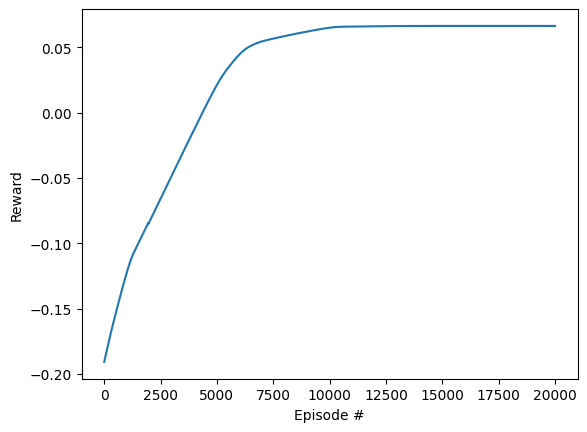

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(reward)+1), reward)
plt.ylabel('Reward')
plt.xlabel('Episode #')
plt.show()

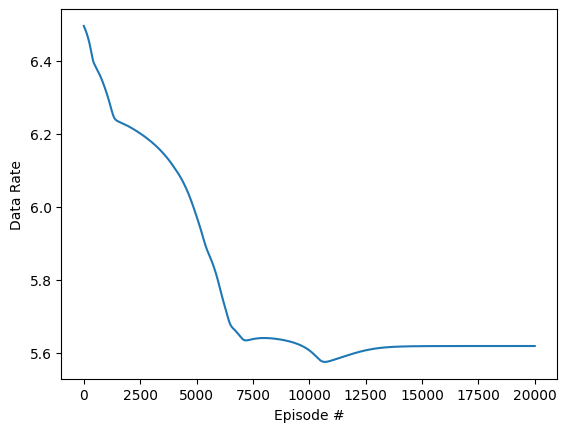

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rate)+1), rate)
plt.ylabel('Data Rate')
plt.xlabel('Episode #')
plt.show()

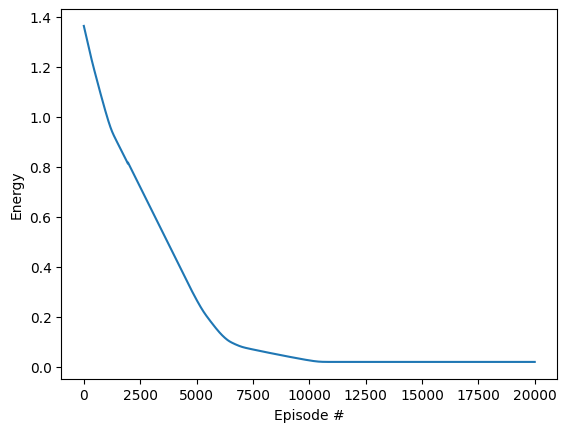

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(energy)+1), energy)
plt.ylabel('Energy')
plt.xlabel('Episode #')
plt.show()